# Difference-in-differences with variation in treatment timing

Prof. Daniel de Abreu Pereira Uhr

## Conteúdo

* Introdução
* TWFE Event Study
* Gardner (2022)
* Borusyak, Jaravel e Spiess (2024)
* Sun & Abraham (2021)


## Referências

**Principais:**
* Borusyak, K., Jaravel, X., & Spiess, J. (2024). Revisiting Event Study Designs: Robust and Efficient Estimation. The Review of Economic Studies, Volume 91, Issue 6, November 2024, Pages 3253–3285, https://doi.org/10.1093/restud/rdae007 
* Gardner, J. (2022). "Two-stage differences in differences," Papers 2207.05943, arXiv.org. https://arxiv.org/abs/2207.05943 
* Sun, L., & Abraham, M. (2021). Estimating Dynamic Treatment Effects in Event Studies with Heterogeneous Treatment Effects. Journal of Econometrics, 222(2), 1011-1033. https://doi.org/10.1016/j.jeconom.2020.09.006
* Stevenson, Betsey, Wolfers, Justin, 2006. Bargaining in the shadow of the law: Divorce laws and family distress. Q. J. Econ. 121 (1), 267–288.



**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

### Introdução

Nesse material temos a aplicação manual dos seguintes estimadores:
* TWFE Event Study
* Gardner (2021)
* Borusyak, Jaravel e Spiess (2023)
* Sun & Abraham (2021)

Vamos dar uma breve comentada na estrutura do estimador, e posteriormente aplicamos "na mão" cada um deles.

Base de dados que utilizaremos para as aplicações

In [77]:
import pandas as pd
# Carregar a base de dados
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/bacon_example.dta")

Filtragem das variáveis

In [78]:
# Resultado/Outcome (Suicide Mortality)
df['Y'] = df['asmrs']
# Treatment D (Staggered treatment adoption)
df['D'] = df['post']
# Covariáveis - pcinc asmrh cases
df['X1'] = df['pcinc']
df['X2'] = df['asmrh']
df['X3'] = df['cases']

# Identificação do painel
df['year'] = df['year'].astype(int)
df['id'] = df['stfips'].astype('category').cat.codes + 1

# Relative time (Tempo relativo até o tratamento - ocorre somente para os tratados)
df['reltime'] = df['year'] - df['_nfd']
# colocar valor zero caso tenha dados faltantes
df['reltime'] = df['reltime'].fillna(0)
# garantir que 'reltime' seja um inteiro
df['reltime'] = df['reltime'].astype(int)

# Generates a new column called 'ct' containing the numerics version of calendar time 'year'
df['ct'] = df['year'] - 1964

# Vamos criar a variável de grupo (cohoort) e G (Callaway-SantAnna)
df['cohort'] = df['_nfd'] - 1965
df['G']=df['_nfd']

# Grupo dos não-tratados (control group)
df['treated'] = 0
df.loc[df['_nfd'] > 0, 'treated'] = 1
df['control_group'] = 1
df.loc[df['treated'] == 1, 'control_group'] = 0

# Criar uma coluna que identifica os indivíduos que nunca foram tratados (nevertreated)
df['nevertreated'] = 0
df.loc[df['treated'] == 0, 'nevertreated'] = 1

# Criar uma coluna que identifica os indivíduos que sempre foram tratados (alwaystreated) 
# Deve ser 1 para todos os anos após o tratamento D
df['mean_treat'] = df.groupby('id')['D'].transform('mean')

# Criar os sempre tratados
df['alwaystreated'] = 0
df.loc[(df['mean_treat'] == 1), 'alwaystreated'] = 1

### TWFE Event Study

Abaixo está um pipeline TWFE “tradicional” com parâmetros no topo para escolher o grupo de controle (all, not_yet, never), o período de referência do event study e (opcionalmente) uma janela de leads/lags

Interpretação dos controles (amostra usada no TWFE):

* all (padrão “TWFE clássico”): usa todos os dados (never + not_yet + pós-tratamento).
* not_yet: exclui os never do painel — controles vêm só dos ainda-não-tratados (entre os ever-treated).
* never: remove os períodos pré-tratamento das unidades ever-treated, mantendo apenas (i) os pós das tratadas e (ii) todos os never. Assim, o contraste é “tratados (pós) vs nunca”.

In [ ]:
import statsmodels.formula.api as smf
# Regressão controlando os efeitos fixos id e ano, com erro padrão robusto à heterocedasticidade.
reg1 = smf.wls('Y ~ D + C(id) + C(year)', data=df).fit(cov_type='cluster')
#print(reg1.summary())

print(reg1.summary2().tables[1].loc[['Intercept', 'D'], :].round(4))

             Coef.  Std.Err.        z   P>|z|   [0.025   0.975]
Intercept  42.5023    2.4121  17.6206  0.0000  37.7747  47.2299
D          -3.0799    1.2677  -2.4295  0.0151  -5.5646  -0.5953


=== TWFE — ATT médio ===
ATT            : -3.0799
SE (cluster id):  2.4939
p-valor        :  0.2168
IC 95%         : [-7.9679,  1.8081]


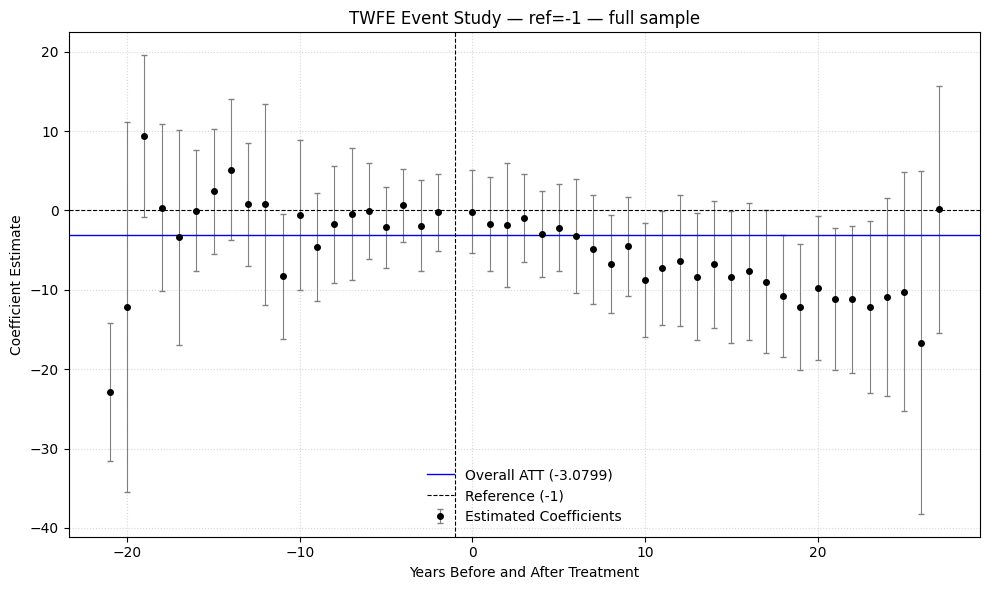

In [102]:
# ============================================================
# TWFE tradicional (ATT + Event Study) no mesmo padrão
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import matplotlib.pyplot as plt

# --------- Parâmetros ----------
REF            = -1        # período de referência no event study
WINDOW         = None      # ex.: (-10, 10) para limitar a janela dos leads/lags
ADD_COVS       = ""        # ex.: "+ X1 + X2 + X3"
INCLUDE_NEVER  = True      # True: usa todos (padrão TWFE); False: usa só ever-treated

# --------- Preparação ----------
df_twfe = df.copy()

# G (ano de adoção) – usa _nfd se G não existir
if "G" not in df_twfe.columns:
    if "_nfd" in df_twfe.columns:
        df_twfe["G"] = df_twfe["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd'.")

# tipos e variáveis básicas
df_twfe["id"]   = df_twfe["id"].astype("category")
df_twfe["year"] = pd.to_numeric(df_twfe["year"], errors="coerce").astype(int)
df_twfe["G"]    = pd.to_numeric(df_twfe["G"],    errors="coerce").fillna(np.inf)

# indicador de tratamento e tempo relativo (apenas para ever-treated)
ever = np.isfinite(df_twfe["G"].values)
df_twfe["D"]        = (ever & (df_twfe["year"].astype(float) >= df_twfe["G"].values)).astype(int)
df_twfe["rel_year"] = np.where(ever, df_twfe["year"] - df_twfe["G"], np.nan)

# opcional: excluir nunca tratados do TWFE
if not INCLUDE_NEVER:
    df_twfe = df_twfe[ever].copy()

# janela opcional para reduzir categorias extremas no gráfico
if WINDOW is not None:
    lo, hi = WINDOW
    df_twfe.loc[(df_twfe["rel_year"] < lo) | (df_twfe["rel_year"] > hi), "rel_year"] = np.nan

# --------- 1) ATT em TWFE (cluster por id) ----------
fml_att = f"Y ~ D + C(id) + C(year) {ADD_COVS}"
y_att, X_att = dmatrices(fml_att, data=df_twfe, return_type="dataframe")
groups_att   = df_twfe.loc[y_att.index, "id"]  # alinhado com o modelo

fit_att = sm.OLS(y_att, X_att).fit(
    cov_type="cluster",
    cov_kwds={"groups": pd.factorize(groups_att)[0]}
)

att      = float(fit_att.params.get("D"))
se_att   = float(fit_att.bse.get("D"))
p_att    = float(fit_att.pvalues.get("D"))
ci_lo_att, ci_hi_att = map(float, fit_att.conf_int().loc["D"])

print("=== TWFE — ATT médio ===")
print(f"ATT            : {att: .4f}")
print(f"SE (cluster id): {se_att: .4f}")
print(f"p-valor        : {p_att: .4f}")
print(f"IC 95%         : [{ci_lo_att: .4f}, {ci_hi_att: .4f}]")

# ---------- 2) Event Study em TWFE com dummies manuais (nomes "seguros") ----------

# referência: se REF não existir nos dados, usa o maior negativo; senão 0
rel_vals = df_twfe.loc[np.isfinite(df_twfe["G"]) & df_twfe["rel_year"].notna(), "rel_year"].astype(int)
ref_val  = REF if (rel_vals == REF).any() else (max([v for v in rel_vals.unique() if v < 0]) if (rel_vals < 0).any() else 0)

# lista de k (leads/lags) a usar, exceto a referência
ks = sorted(int(k) for k in rel_vals.unique() if k != ref_val)

def safe_name(k: int) -> str:
    return f"es_m{abs(k)}" if k < 0 else f"es_{k}"

# cria dummies de evento só para ever-treated; never tratados ficam 0
es_cols = []
name2k  = {}
ever    = np.isfinite(df_twfe["G"].values)

for k in ks:
    col = safe_name(k)
    name2k[col] = k
    df_twfe[col] = ((df_twfe["rel_year"].astype("float").round().astype("Int64") == k) & ever).fillna(False).astype(int)
    es_cols.append(col)

# fórmula do event study: dummies + FE + (opcionais) covariáveis
rhs_es = " + ".join(es_cols + ["C(id)", "C(year)"]) + (f" {ADD_COVS}" if ADD_COVS.strip() else "")
fml_es = f"Y ~ {rhs_es}"

# monta matrizes e ajusta (cluster por id)
from patsy import dmatrices
y_es, X_es = dmatrices(fml_es, data=df_twfe, return_type="dataframe")
groups_es  = df_twfe.loc[y_es.index, "id"]

fit_es = sm.OLS(y_es, X_es).fit(
    cov_type="cluster",
    cov_kwds={"groups": pd.factorize(groups_es)[0]}
)

# ---------- 3) Tabela coef + IC para plot ----------
params = fit_es.params.rename("estimate").to_frame()
ci = fit_es.conf_int(); ci.columns = ["ci_lower","ci_upper"]
est = (
    params.join(ci, how="inner")
          .reset_index().rename(columns={"index":"term"})
)
est = est[est["term"].isin(es_cols)].copy()
est["relative_period"] = est["term"].map(name2k)
est = est.sort_values("relative_period")

# ---------- 4) Gráfico no mesmo estilo ----------
plt.figure(figsize=(10,6))
plt.errorbar(
    est["relative_period"], est["estimate"],
    yerr=[est["estimate"] - est["ci_lower"], est["ci_upper"] - est["estimate"]],
    fmt='o', color='black', markersize=4,
    ecolor='gray', elinewidth=0.8, capsize=2,
    label='Estimated Coefficients'
)

# linhas de referência
plt.axhline(att, color='blue', linestyle='-',  linewidth=1, label=f'Overall ATT ({att:.4f})')
plt.axhline(0,   color='black', linestyle='--', linewidth=0.8)
plt.axvline(ref_val, color='black', linestyle='--', linewidth=0.8, label=f'Reference ({ref_val})')

plt.title(f"TWFE Event Study — ref={ref_val}" + (" — ever-treated" if not INCLUDE_NEVER else " — full sample"))
plt.xlabel("Years Before and After Treatment")
plt.ylabel("Coefficient Estimate")
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


### Gardner (2021)

=== DID2S (Gardner) — ATT médio | controle = not_yet ===
ATT            : -6.1870
SE (cluster id):  1.9748
p-valor        :  0.0017
IC 95%         : [-10.0575, -2.3165]


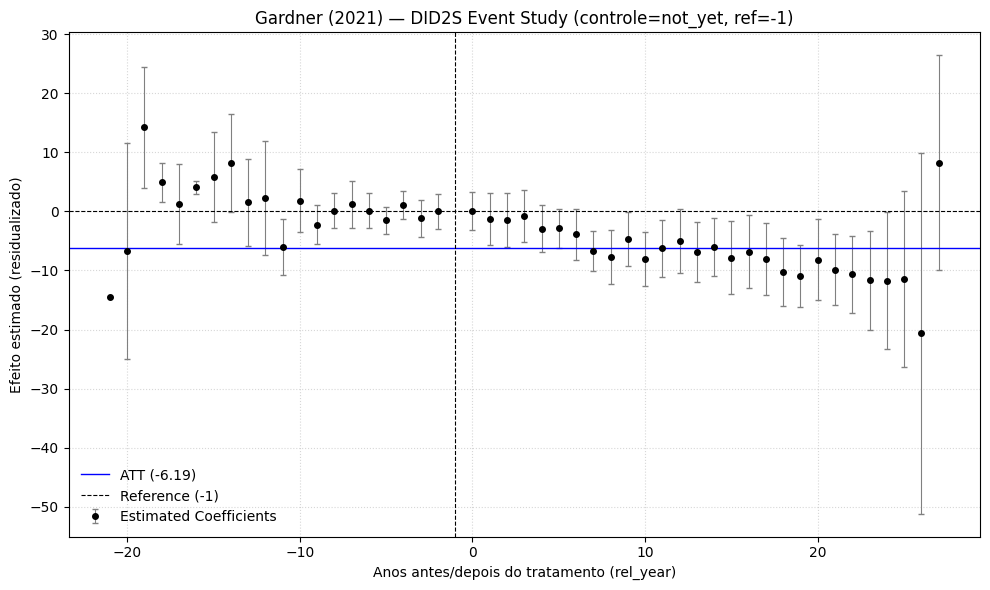

In [104]:
# ============================================================
# Gardner (2021) - DID2S com opção de controle e ES estilizado
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ---------- Parâmetros ----------
CONTROL       = "not_yet"   # "not_yet" (recomendado) ou "never" (gera calculo errado)
REF           = -1          # período de referência do event study
WINDOW        = None        # ex.: (-10, 10) ou None
ADD_COVS      = ""          # ex.: "+ X1 + X2 + X3"
SHOW_ATT_LINE = True        # desenhar linha horizontal com ATT médio no gráfico
SHOW_REF_POINT = False      # se True, mantém o coeficiente da referência no gráfico


# ---------- Preparos ----------
df = df.copy()

# Se sua base não tiver 'G' explícito, use '_nfd' como G (ano de primeira adoção)
if "G" not in df.columns:
    if "_nfd" in df.columns:
        df["G"] = df["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd' na base.")

# Tipos e coerções
df["id"]   = df["id"].astype("category")
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype(int)
df["G"]    = pd.to_numeric(df["G"],    errors="coerce").fillna(np.inf)

# Tratamento e tempo relativo (para ever-treated)
df["D"] = ((np.isfinite(df["G"])) & (df["year"].astype(float) >= df["G"])).astype(int)
df["rel_year"] = np.where(np.isfinite(df["G"]), df["year"] - df["G"], np.nan)

# (opcional) limitar janela de leads/lags para o gráfico
if WINDOW is not None:
    lo, hi = WINDOW
    df.loc[(df["rel_year"] < lo) | (df["rel_year"] > hi), "rel_year"] = np.nan

# ---------- 1ª etapa (FE em id + year) ----------
if CONTROL == "not_yet":
    # clássico Gardner/BJS: usa observações ainda-não-tratadas (D==0)
    sub = df[df["D"] == 0].copy()
elif CONTROL == "never":
    # usa apenas os nunca tratados (G == +inf)
    sub = df[~np.isfinite(df["G"])].copy()
else:
    raise ValueError("CONTROL deve ser 'not_yet' ou 'never'.")

# Fórmula do 1º estágio (com FE) e covariáveis opcionais
fml_stage1 = f"Y ~ C(id) + C(year) {ADD_COVS} - 1"
fit_stage1 = smf.ols(fml_stage1, data=sub).fit()

# Cobertura de ids treinados (importante quando CONTROL='never')
ids_train = set(sub["id"].cat.categories if hasattr(sub["id"], "cat") else sub["id"].unique())
ids_full  = set(df["id"].cat.categories if hasattr(df["id"], "cat") else df["id"].unique())
missing_ids = sorted(list(ids_full - ids_train))

# Predição contrafactual de FE: Yhat = FE_id + FE_year (+ covs)
df["_Yhat_fe"] = fit_stage1.predict(df)

# Caso 'never' falte algum id no treino, faça fallback apenas com C(year) (+ covs)
if CONTROL == "never" and len(missing_ids) > 0:
    print(f"Aviso: {len(missing_ids)} ids tratados não apareceram no treino (controle='never'). "
          f"Previsões para esses ids usarão somente efeitos de ano (C(year)) + covariáveis.")
    fit_year = smf.ols(f"Y ~ C(year) {ADD_COVS} - 1", data=sub).fit()
    mask_missing = df["id"].isin(missing_ids)
    df.loc[mask_missing, "_Yhat_fe"] = fit_year.predict(df[mask_missing])

# Resíduo “purificado” por FE (primeiro passo Gardner)
df["_resid"] = df["Y"] - df["_Yhat_fe"]

# ---------- 2ª etapa: ATT médio (DID2S) ----------
fit_att = smf.ols("_resid ~ D - 1", data=df).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["id"]}  # cluster por id
)

att      = float(fit_att.params["D"])
se       = float(fit_att.bse["D"])
pval     = float(fit_att.pvalues["D"])
ci_low, ci_high = map(float, fit_att.conf_int().loc["D"].tolist())

print(f"=== DID2S (Gardner) — ATT médio | controle = {CONTROL} ===")
print(f"ATT            : {att: .4f}")
print(f"SE (cluster id): {se: .4f}")
print(f"p-valor        : {pval: .4f}")
print(f"IC 95%         : [{ci_low: .4f}, {ci_high: .4f}]")

att_tbl = pd.DataFrame(
    {"coef":[att], "se(cluster id)":[se], "p_value":[pval], "ci_low":[ci_low], "ci_high":[ci_high]},
    index=["ATT (DID2S)"]
)
# print(att_tbl.round(4))  # descomente se quiser ver a tabela

# ---------- 2ª etapa: Event Study (leads/lags) ----------
# Somente ever-treated entram (rel_year não nulo)
df_es = df[df["rel_year"].notna()].copy()
df_es["rel_year"] = df_es["rel_year"].astype(int)

# Se REF não existir na amostra, define automaticamente (último negativo, ou 0)
ref_val = REF
if not (df_es["rel_year"] == ref_val).any():
    negs = sorted([x for x in df_es["rel_year"].unique() if x < 0])
    ref_val = negs[-1] if negs else 0

# Remover NAs que entram no modelo (mantém alinhamento com clusters)
df_es = df_es.dropna(subset=["_resid", "rel_year", "id"]).copy()

# ES com referência 'ref_val' e sem intercepto
fml_es = f"_resid ~ C(rel_year, Treatment(reference={ref_val})) - 1"
fit_es = smf.ols(fml_es, data=df_es).fit(
    cov_type="cluster", cov_kwds={"groups": df_es["id"]}
)

# Organizar coeficientes e IC
params = fit_es.params.rename("coef").to_frame()
ci = fit_es.conf_int(); ci.columns = ["ci_low","ci_high"]
est = (
    params.join(ci)
          .reset_index()
          .rename(columns={"index":"term"})
)

# extrair número do rel_year
est["rel_year"] = est["term"].str.extract(r"\[T?\.?(-?\d+)\]")[0].astype(float)
est = est.dropna(subset=["rel_year"]).sort_values("rel_year")

# >>> remover o ponto de referência, se for o caso
if not SHOW_REF_POINT:
    est = est[est["rel_year"] != ref_val]

# ====== gráfico “clean” estilo desejado ======
plt.figure(figsize=(10, 6))

# pontos + IC (fininho, caps curtos)
plt.errorbar(
    est["rel_year"],
    est["coef"],
    yerr=[est["coef"] - est["ci_low"], est["ci_high"] - est["coef"]],
    fmt='o',
    color='black',
    markersize=4,
    ecolor='gray',
    elinewidth=0.8,
    capsize=2,
    label='Estimated Coefficients'
)

# linha horizontal em 0 (baseline na referência)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# (opcional) desenhar linha horizontal com o ATT médio
if SHOW_ATT_LINE:
    plt.axhline(att, color='blue', linestyle='-', linewidth=1,
                label=f'ATT ({att:.2f})')

# linha vertical marcando a referência (tipicamente -1)
plt.axvline(ref_val, color='black', linestyle='--', linewidth=0.8,
            label=f'Reference ({ref_val})')

# (opcional) marcar também t=0 (início do tratamento)
# plt.axvline(0, color='red', linestyle='--', linewidth=0.8, label='Treatment start (0)')

# título e rótulos
plt.title(f'Gardner (2021) — DID2S Event Study (controle={CONTROL}, ref={ref_val})', fontsize=12)
plt.xlabel('Anos antes/depois do tratamento (rel_year)', fontsize=10)
plt.ylabel('Efeito estimado (residualizado)', fontsize=10)

# legenda e estética
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


### Borusyak, Jaravel e Spiess (2023)

=== BJS (2023) — ATT médio | controle = not_yet ===
ATT            : -6.1870
SE (cluster id):  1.9822
p-valor        :  0.0018
IC 95%         : [-10.0721, -2.3019]


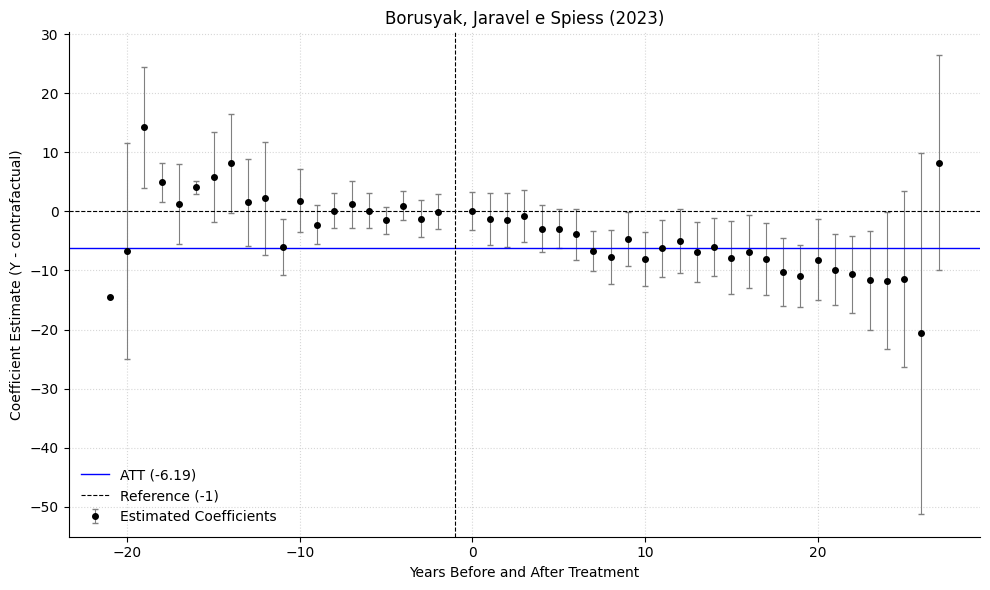

In [106]:
# ============================================================
# BJS (2023) - Imputation DiD com opção de controle: not_yet | never
# (com flags SHOW_REF_POINT e SHOW_ATT_LINE)
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ---------- Parâmetros ----------
CONTROL         = "not_yet"   # "not_yet" (recomendado) ou "never" (pode enviesar)
REF             = -1          # período de referência no event study
WINDOW          = None        # ex.: (-10, 10) para limitar janela; ou None
ADD_COVS        = ""          # ex.: "+ X1 + X2 + X3" para adicionar covariáveis no passo 1
SHOW_REF_POINT  = False       # se False, remove o ponto no baseline (ref) do gráfico
SHOW_ATT_LINE   = True        # desenhar linha horizontal com o ATT médio

# ---------- Preparos ----------
df = df.copy()

# G (ano de primeira adoção)
if "G" not in df.columns:
    if "_nfd" in df.columns:
        df["G"] = df["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd' na base.")

df["id"]   = df["id"].astype("category")
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype(int)
df["G"]    = pd.to_numeric(df["G"],    errors="coerce").fillna(np.inf)

# Tratamento e tempo relativo
df["D"] = ((np.isfinite(df["G"])) & (df["year"].astype(float) >= df["G"])).astype(int)
df["rel_year"] = np.where(np.isfinite(df["G"]), df["year"] - df["G"], np.nan)

# (opcional) janela para limpar extremos no gráfico
if WINDOW is not None:
    lo, hi = WINDOW
    df.loc[(df["rel_year"] < lo) | (df["rel_year"] > hi), "rel_year"] = np.nan

# ---------- Passo 1 (contrafactual) ----------
if CONTROL == "not_yet":
    sub = df[df["D"] == 0].copy()             # clássico BJS: not-yet-treated
elif CONTROL == "never":
    sub = df[~np.isfinite(df["G"])].copy()    # apenas nunca tratados
else:
    raise ValueError("CONTROL deve ser 'not_yet' ou 'never'.")

# fórmula com FE de id e ano; covariáveis opcionais
fml_step1 = f"Y ~ C(id) + C(year) {ADD_COVS} - 1"
fit_cf = smf.ols(fml_step1, data=sub).fit()

# cobertura de ids no treinamento (importante quando CONTROL='never')
ids_train = set(sub["id"].cat.categories if hasattr(sub["id"], "cat") else sub["id"].unique())
ids_full  = set(df["id"].cat.categories if hasattr(df["id"], "cat") else df["id"].unique())
missing_ids = sorted(list(ids_full - ids_train))

if CONTROL == "never" and len(missing_ids) > 0:
    print(f"Aviso: {len(missing_ids)} ids tratados não apareceram no treino (controle='never'). "
          f"Previsões para esses ids usarão somente efeitos de ano (C(year)) + covariáveis.")
    # fallback: modelo só com C(year) (+ covs) para garantir previsão
    fit_year = smf.ols(f"Y ~ C(year) {ADD_COVS} - 1", data=sub).fit()
    df["_Y_cf"] = fit_cf.predict(df)
    mask_missing = df["id"].isin(missing_ids)
    df.loc[mask_missing, "_Y_cf"] = fit_year.predict(df[mask_missing])
else:
    df["_Y_cf"] = fit_cf.predict(df)

# ---------- Tau e ATT (cluster por id) ----------
# tau = Y - Y_cf (para todos; facilita ES com leads e lags)
df["_tau"] = df["Y"] - df["_Y_cf"]

# ATT médio: só períodos tratados
treated = df[df["D"] == 1].copy()
fit_att = smf.ols("_tau ~ 1", data=treated).fit(
    cov_type="cluster", cov_kwds={"groups": treated["id"]}
)

att      = float(fit_att.params["Intercept"])
se       = float(fit_att.bse["Intercept"])
pval     = float(fit_att.pvalues["Intercept"])
ci_low, ci_high = map(float, fit_att.conf_int().loc["Intercept"].tolist())

print(f"=== BJS (2023) — ATT médio | controle = {CONTROL} ===")
print(f"ATT            : {att: .4f}")
print(f"SE (cluster id): {se: .4f}")
print(f"p-valor        : {pval: .4f}")
print(f"IC 95%         : [{ci_low: .4f}, {ci_high: .4f}]")

# ---------- Event Study com IC (cluster por id) ----------
df_es = df[df["rel_year"].notna()].copy()
df_es["rel_year"] = df_es["rel_year"].astype(int)

# referência automática se REF não existir
ref_val = REF
if not (df_es["rel_year"] == ref_val).any():
    negs = sorted([x for x in df_es["rel_year"].unique() if x < 0])
    ref_val = negs[-1] if negs else 0

# remove NAs usados no modelo p/ manter grupos alinhados
df_es = df_es.dropna(subset=["_tau", "rel_year", "id"]).copy()

fml_es = f"_tau ~ C(rel_year, Treatment(reference={ref_val})) - 1"
fit_es = smf.ols(fml_es, data=df_es).fit(
    cov_type="cluster", cov_kwds={"groups": df_es["id"]}
)

# organizar coeficientes
params = fit_es.params.rename("coef").to_frame()
ci = fit_es.conf_int(); ci.columns = ["ci_low","ci_high"]
est = params.join(ci).reset_index().rename(columns={"index":"term"})
est["rel_year"] = est["term"].str.extract(r"\[T?\.?(-?\d+)\]")[0].astype(float)
est = est.dropna(subset=["rel_year"]).sort_values("rel_year")

# opcional: remover o ponto de referência do gráfico
if not SHOW_REF_POINT:
    est = est[est["rel_year"] != ref_val]

# ==== preparar dados no formato “plot_df” ====
plot_df = (
    est.rename(columns={"coef":"estimate", "ci_low":"ci_lower", "ci_high":"ci_upper"})
      .loc[:, ["rel_year", "estimate", "ci_lower", "ci_upper"]]
      .rename(columns={"rel_year":"relative_period"})
      .sort_values("relative_period")
      .reset_index(drop=True)
)

# --- (opcional) média simples dos coeficientes pós-tratamento (t >= 0)
is_post = plot_df["relative_period"] >= 0
mean_weighted = plot_df.loc[is_post, "estimate"].mean()

# ==== gráfico estilo “limpo” ====
try:
    import seaborn as sns
    use_despine = True
except Exception:
    use_despine = False

plt.figure(figsize=(10, 6))

plt.errorbar(
    plot_df["relative_period"],
    plot_df["estimate"],
    yerr=[plot_df["estimate"] - plot_df["ci_lower"],
          plot_df["ci_upper"] - plot_df["estimate"]],
    fmt='o',
    color='black',
    markersize=4,
    ecolor='gray',
    elinewidth=0.8,
    capsize=2,
    label='Estimated Coefficients'
)

# linhas horizontais
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
if SHOW_ATT_LINE:
    plt.axhline(att, color='blue', linestyle='-', linewidth=1,
                label=f'ATT ({att:.2f})')

# linha vertical no período de referência
plt.axvline(ref_val, color='black', linestyle='--', linewidth=0.8,
            label=f'Reference ({ref_val})')
# se quiser marcar também t=0:
# plt.axvline(0, color='red', linestyle='--', linewidth=0.8, label='Treatment start (0)')

plt.title(f'Borusyak, Jaravel e Spiess (2023)',
          fontsize=12)
plt.xlabel('Years Before and After Treatment', fontsize=10)
plt.ylabel('Coefficient Estimate (Y - contrafactual)', fontsize=10)

plt.legend(frameon=False, fontsize=10)
if use_despine:
    sns.despine()
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


### Sun and Abraham (2021)

C:\Users\danie\AppData\Local\Temp\ipykernel_12236\2767716441.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\danie\AppData\Local\Temp\ipykernel_12236\2767716441.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\danie\AppData\Local\Temp\ipykernel_12236\2767716441.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

=== Sun & Abraham (2021) — Event-Study agregado por k ===
N dummies (k×coorte) usadas: 384
    rel_year  estimate       se  ci_lower  ci_upper
0        -21  -13.9356   6.3348  -26.3517   -1.5194
1        -20  -10.2438   5.4260  -20.8787    0.3912
2        -19    9.3815   6.3318   -3.0288   21.7919
3        -18    2.0571   6.3838  -10.4551   14.5693
4        -17   -0.2594   5.8177  -11.6622   11.1434
5        -16    4.0954   4.9655   -5.6370   13.8278
6        -15    5.9236   4.2628   -2.4314   14.2787
7        -14    8.0162   4.5954   -0.9908   17.0233
8        -13    2.7152   9.3188  -15.5496   20.9801
9        -12    0.7283  12.9408  -24.6357   26.0922
10       -11   -6.8203   8.2718  -23.0329    9.3924
11       -10    3.0205   7.2804  -11.2492   17.2902
12        -9   -2.3001   4.4834  -11.0875    6.4873
13        -8   -0.3830   4.9494  -10.0837    9.3178
14        -7    0.0162   5.4751  -10.7149   10.7474
15        -6   -0.6486   3.8511   -8.1967    6.8995
16        -5   -2.5901   

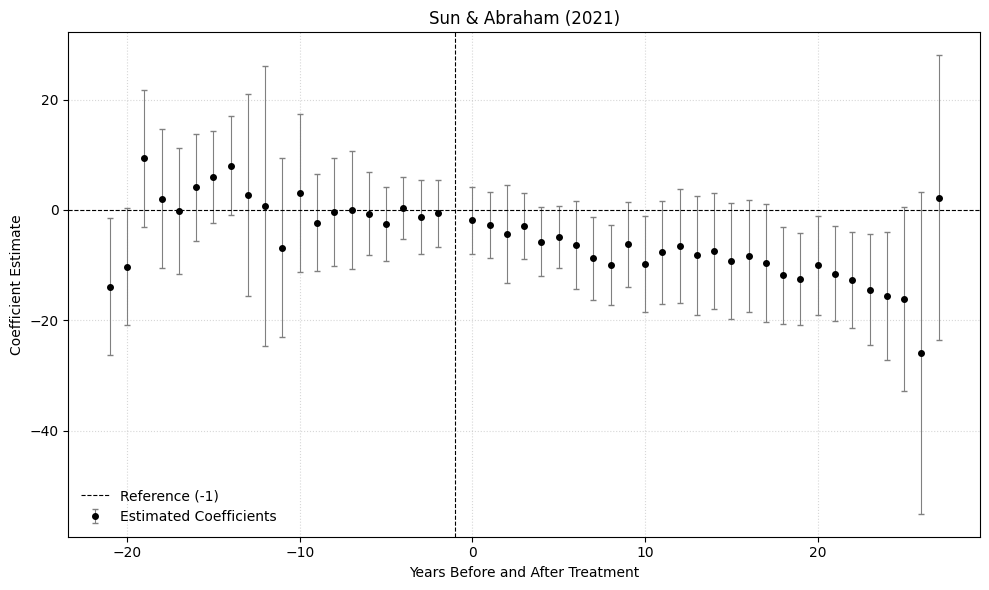

In [111]:
# ============================================================
# Sun & Abraham (2021) — Event-Study por coorte + agregação
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import matplotlib.pyplot as plt

# ---------- Parâmetros ----------
REF           = -1          # período de referência (lead) omitido no ES
WINDOW        = None        # ex.: (-10, 10) para limpar extremos; ou None
ADD_COVS      = ""          # ex.: "+ X1 + X2 + X3"
SHOW_ATT_LINE = True        # desenhar linha horizontal com "overall pós" no gráfico

# ---------- Preparos ----------
df_sa = df.copy()

# G (ano de 1ª adoção) — se não existir 'G', usa '_nfd'
if "G" not in df_sa.columns:
    if "_nfd" in df_sa.columns:
        df_sa["G"] = df_sa["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd' na base.")

# Tipos e coerções
df_sa["id"]   = df_sa["id"].astype("category")
df_sa["year"] = pd.to_numeric(df_sa["year"], errors="coerce").astype(int)
df_sa["G"]    = pd.to_numeric(df_sa["G"],    errors="coerce")

# ever-treated (G finito) vs nunca tratados (G NaN)
df_sa["treated_ever"] = np.isfinite(df_sa["G"]).astype(int)

# rel_year apenas para ever-treated; nunca tratados ficam NaN
df_sa["rel_year"] = np.where(df_sa["treated_ever"] == 1, df_sa["year"] - df_sa["G"], np.nan)
df_sa["rel_year"] = pd.to_numeric(df_sa["rel_year"], errors="coerce")

# (opcional) janela para limpar extremos no gráfico
if WINDOW is not None:
    lo, hi = WINDOW
    df_sa.loc[(df_sa["rel_year"] < lo) | (df_sa["rel_year"] > hi), "rel_year"] = np.nan

# ---------- Coortes e suporte de k ----------
cohorts = np.sort(df_sa.loc[df_sa["treated_ever"] == 1, "G"].dropna().unique())
Ks_all = (
    df_sa.loc[(df_sa["treated_ever"] == 1) & (df_sa["rel_year"].notna()), "rel_year"]
         .dropna()
         .astype(int)
         .unique()
)
# exclui a referência (REF)
Ks = sorted([int(k) for k in Ks_all if int(k) != int(REF)])

# Helper p/ nomes "seguros" (sem '-')
def tag_k(k: int) -> str:
    return f"km{abs(k)}" if k < 0 else f"k{k}"

def tag_g(g_val) -> str:
    # g pode ser float; use inteiro para tag
    try:
        return f"g{int(g_val)}"
    except Exception:
        return f"g{g_val}"

# ---------- Construir dummies (k × coorte) ----------
# Cada regressor sa_k{±}_g{coorte} = 1{rel_year=k & G=g} (apenas para ever-treated)
sa_cols = []
meta = []  # mapeia col -> (k, g)

for g in cohorts:
    g_mask = (df_sa["treated_ever"] == 1) & (df_sa["G"] == g)
    for k in Ks:
        col = f"sa_{tag_k(k)}_{tag_g(g)}"
        df_sa[col] = ((g_mask) & (df_sa["rel_year"].astype(float) == float(k))).astype(int)
        # só guarda se existir pelo menos 1 ocorrência
        if df_sa[col].sum() > 0:
            sa_cols.append(col)
            meta.append((col, int(k), int(g)))

# Se nada foi criado, aborta com dica
if len(sa_cols) == 0:
    raise RuntimeError("Nenhum regressor (k×coorte) foi criado. "
                       "Verifique G/rel_year/REF/WINDOW.")

# ---------- Regressão SA: Y ~ sum_{k≠REF,g} 1{rel_year=k,G=g} + FE_i + FE_t (+ X)
rhs = " + ".join(sa_cols) + " + C(id) + C(year)" + (f" {ADD_COVS}" if ADD_COVS.strip() else "")
fml = f"Y ~ {rhs}"

# use patsy para garantir alinhamento e depois rode OLS com SEs clusterizados
y, X = dmatrices(fml, data=df_sa, return_type="dataframe")
# clusters alinhados às linhas de y
groups = df_sa.loc[y.index, "id"]
fit_sa = sm.OLS(y, X).fit(
    cov_type="cluster",
    cov_kwds={"groups": pd.factorize(groups)[0]}
)

# ---------- Agregação por k (ponderando por frequência de (k,g)) ----------
# pesos w_{k,g} proporcionais ao # de observações com rel_year=k e G=g (no y, ou no df)
weights = {}
for col, k, g in meta:
    weights.setdefault(k, {})
    # conte as ocorrências no design (ou na base); aqui no df_sa é ok
    w = int(df_sa[col].sum())
    if w > 0:
        weights[k][col] = w

# normaliza por k
for k in list(weights.keys()):
    s = sum(weights[k].values())
    if s == 0:
        del weights[k]
        continue
    for col in weights[k]:
        weights[k][col] = weights[k][col] / s

# extrair betas e covariância
beta = fit_sa.params
V    = fit_sa.cov_params()

# para cada k, est_k = w' beta_{k,.}; Var(est_k) = w' V_{k,.} w
rows = []
for k in sorted(weights.keys()):
    cols_k = list(weights[k].keys())
    w_vec  = np.array([weights[k][c] for c in cols_k])

    b_vec = beta.reindex(cols_k).to_numpy()
    # submatriz de covariância
    V_kk = V.loc[cols_k, cols_k].to_numpy()

    est_k = float(w_vec @ b_vec)
    var_k = float(w_vec @ V_kk @ w_vec)
    se_k  = float(np.sqrt(max(var_k, 0.0)))

    ci_low = est_k - 1.96 * se_k
    ci_high = est_k + 1.96 * se_k

    rows.append({"rel_year": k, "estimate": est_k, "se": se_k,
                 "ci_lower": ci_low, "ci_upper": ci_high})

est = pd.DataFrame(rows).sort_values("rel_year").reset_index(drop=True)

# (opcional) “overall pós” (média ponderada por frequência entre k>=0)
is_post = est["rel_year"] >= 0
if is_post.any():
    # peso para cada k: total de obs naquela “linha k” (soma dos w brutos)
    w_k_raw = []
    for k in est.loc[is_post, "rel_year"]:
        w_k_raw.append(sum(int(df_sa[c].sum()) for c, kk, _g in meta if kk == k))
    w_k = np.array(w_k_raw, dtype=float)
    w_k = w_k / w_k.sum()
    overall_post = float(np.dot(w_k, est.loc[is_post, "estimate"]))
else:
    overall_post = np.nan

# ---------- Saídas textuais resumidas ----------
print("=== Sun & Abraham (2021) — Event-Study agregado por k ===")
print(f"N dummies (k×coorte) usadas: {len(sa_cols)}")
print(est.round(4))

# ---------- Gráfico (estilo clean) ----------
plt.figure(figsize=(10, 6))
plt.errorbar(
    est["rel_year"],
    est["estimate"],
    yerr=[est["estimate"] - est["ci_lower"], est["ci_upper"] - est["estimate"]],
    fmt='o',
    color='black',
    markersize=4,
    ecolor='gray',
    elinewidth=0.8,
    capsize=2,
    label='Estimated Coefficients'
)

# linha horizontal em 0 (baseline na referência)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# marca a referência no eixo x
plt.axvline(REF, color='black', linestyle='--', linewidth=0.8,
            label=f'Reference ({REF})')
# se quiser marcar o início do tratamento (0):
# plt.axvline(0, color='red', linestyle='--', linewidth=0.8, label='Treatment start (0)')

plt.title('Sun & Abraham (2021)', fontsize=12)
plt.xlabel('Years Before and After Treatment', fontsize=10)
plt.ylabel('Coefficient Estimate', fontsize=10)
plt.legend(frameon=False, fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


Estimando um efeito ATT (SA) médio

In [115]:
# ===== Sun & Abraham — ATT (post) agregado (robusto) =====
import numpy as np
import pandas as pd
from scipy.stats import t

# 1) Identificar as colunas sa_* que realmente entraram no design
cols_in_X = set(X.columns)
sa_in_design = [(col, k, g) for (col, k, g) in meta if col in cols_in_X]

# 2) Definir o que é "pós" baseado no REF
def is_post_k(k, ref):
    if ref < 0:
        return k >= 0
    elif ref == 0:
        return k >= 1
    else:
        return k > ref

cols_post = [col for (col, k, g) in sa_in_design if is_post_k(k, REF)]

if len(cols_post) == 0:
    ks_kept = sorted(set(k for (_c, k, _g) in sa_in_design))
    raise RuntimeError(f"Sem colunas pós-tratamento no design. REF={REF}. ks no design: {ks_kept}")

# 3) Pesos por frequência amostral (nas linhas que entraram no OLS)
in_design_rows = df_sa.index.isin(y.index)
w_raw = np.array([df_sa.loc[in_design_rows, c].sum() for c in cols_post], dtype=float)
w_raw[(~np.isfinite(w_raw)) | (w_raw == 0)] = 1.0
w = w_raw / w_raw.sum()

# 4) Combinação linear: att = w' beta_post ; Var = w' V_post w
beta = fit_sa.params.reindex(cols_post).to_numpy()
V    = fit_sa.cov_params().loc[cols_post, cols_post].to_numpy()

att_sa = float(w @ beta)
var_sa = float(w @ V @ w)
se_sa  = float(np.sqrt(max(var_sa, 0.0)))

# Graus de liberdade para t com cluster-robusto: n_grupos - 1
g_ids = pd.factorize(df_sa.loc[y.index, "id"])[0]
df_t  = int(np.unique(g_ids).size - 1)

t_stat = att_sa / se_sa if se_sa > 0 else np.nan
p_val  = 2 * (1 - t.cdf(abs(t_stat), df=df_t)) if np.isfinite(t_stat) else np.nan
ci_low = att_sa - t.ppf(0.975, df=df_t) * se_sa
ci_high= att_sa + t.ppf(0.975, df=df_t) * se_sa

print("\n=== Sun & Abraham (2021) — ATT (post) agregado ===")
print(f"ATT (post)     : {att_sa: .4f}")
print(f"SE (cluster id): {se_sa: .4f}")
print(f"t              : {t_stat: .3f} (gl={df_t})")
print(f"p-valor        : {p_val: .4f}")
print(f"IC 95%         : [{ci_low: .4f}, {ci_high: .4f}]")

# (opcional) se quiser que a linha do gráfico mostre este ATT (post):
# plt.axhline(att_sa, color='blue', linestyle='-', linewidth=1, label=f'ATT post ({att_sa:.2f})')



=== Sun & Abraham (2021) — ATT (post) agregado ===
ATT (post)     : -8.1389
SE (cluster id):  3.6098
t              : -2.255 (gl=48)
p-valor        :  0.0288
IC 95%         : [-15.3970, -0.8809]


* Se você tiver muitos clusters, tanto faz (z ≈ t).
* Se tiver poucos clusters, o t com gl=G–1 é mais conservador e mais correto.

In [116]:
from scipy.stats import t

G = df_sa["id"].nunique()   # número de clusters
df_dof = G - 1

t_stat = att_sa / se_sa if se_sa > 0 else np.nan
p_val = 2 * (1 - t.cdf(abs(t_stat), df=df_dof))
ci_low = att_sa - t.ppf(0.975, df=df_dof) * se_sa
ci_high = att_sa + t.ppf(0.975, df=df_dof) * se_sa

print("\n=== Sun & Abraham (2021) — ATT (post) agregado ===")
print(f"ATT (post)     : {att_sa: .4f}")
print(f"SE (cluster id): {se_sa: .4f}")
print(f"t              : {t_stat: .3f} (gl={df_dof})")
print(f"p-valor        : {p_val: .4f}")
print(f"IC 95%         : [{ci_low: .4f}, {ci_high: .4f}]")



=== Sun & Abraham (2021) — ATT (post) agregado ===
ATT (post)     : -8.1389
SE (cluster id):  3.6098
t              : -2.255 (gl=48)
p-valor        :  0.0288
IC 95%         : [-15.3970, -0.8809]


### Comparando os modelos em um mesmo gráfico


Talvez seja conveniente visualizar os resultados dos diferentes estimadores em um mesmo gráfico.